### 策略：登录1次的预测为p2，不是登录1次的回归

In [1]:
import pandas as pd
import numpy as np
import random
import gc
import seaborn as sns
import lightgbm as lgb
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler, StandardScaler
from sklearn.metrics import recall_score, auc, accuracy_score, f1_score, precision_score, classification_report, roc_auc_score,mean_squared_error
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime
import missingno as msno
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [2]:
data = pd.read_csv('./FE_data/data.csv')

In [3]:
for col in data.columns:
    print(col,data[col].skew())
    

role_id -1.4711917383735937
r1 6.004764747011181
r2 32.97521237646333
r3 6.937526958531136
r4 5.395824756830449
max_role_level 4.123416277956089
p1 24.611934752023775
p2 82.97912434384163
p3 773.7040754334217
p4 875.3973801981961
p5 24.632336305552215
p6 83.2619214775587
is_create_role -4.310131398524176
is_create_no -2.6044486939863347
server_sum 42.86670864602986
platform 1.495073376088881
user_type 3.935639029485368
user_flag 17.26662989578684
mobile 1.6710294837056292
game_pay_num 63.126718760857294
chmoney_pay_num 177.36200872449115
30d_pay_money 81.31200401355774


In [5]:
data[data['r1'] <=1].shape

(3384512, 22)

In [7]:
data[data['r1'] <=1]['30d_pay_money'].sum()

499460.0

In [8]:
data[data['r1'] <=1]['p2'].sum()

97202.0

In [55]:
data_train, data_test = train_test_split(data, test_size=0.25)

In [56]:
data_train['30d_pay_money'].describe()

count    3.873323e+06
mean     1.878829e+01
std      5.862021e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.567880e+05
Name: 30d_pay_money, dtype: float64

In [57]:
data_test['30d_pay_money'].describe()

count    1.291108e+06
mean     1.788269e+01
std      5.472365e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.766600e+04
Name: 30d_pay_money, dtype: float64

In [58]:
data_train.shape

(3873323, 22)

In [59]:
data_train[data_train['r1'] <=1].shape

(2538050, 22)

In [60]:
print(data_train[data_train['r1'] <=1]['p2'].sum())
print(data_train[data_train['r1'] <=1]['30d_pay_money'].sum())

72146.0
379536.0


In [61]:
data_train_r1 = data_train[data_train['r1'] >1]
print(data_train_r1.shape)
display(data_train_r1['30d_pay_money'].describe())

(1335273, 22)


count    1.335273e+06
mean     5.421630e+01
std      9.963497e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.567880e+05
Name: 30d_pay_money, dtype: float64

In [62]:
pd.set_option('display.max_columns', None)
data_train_r1.head()

,role_id,r1,r2,r3,r4,max_role_level,p1,p2,p3,p4,p5,p6,is_create_role,is_create_no,server_sum,platform,user_type,user_flag,mobile,game_pay_num,chmoney_pay_num,30d_pay_money
2700407,12411452,8,1,1,0.01,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
1840507,12636397,7,1,1,0.01,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
1575578,137420272,2,1,1,0.17,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,18.0,1.0,0.0,0.0,0.0,0.0
4288699,135573300,19,1,10,3.79,52,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2337095,13511029,5,1,1,0.24,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0


In [63]:
data_train_r1= data_train_r1[data_train_r1['30d_pay_money']<60000]

In [64]:
x = data_train_r1.drop(['role_id','30d_pay_money'],axis=1)
for col in x.columns:
    x[col] = np.log1p(x[col])
y = data_train_r1['30d_pay_money']
y_ln = np.log1p(y)
x_train, x_val, y_train, y_val = train_test_split(x, y_ln, test_size=0.2)

In [12]:
# from sklearn.linear_model import Lasso
# lasso = Lasso()
# lasso.fit(x_train, y_train)
# print(lasso.coef_)
# print(len(lasso.coef_))

In [13]:
# none_mean = []
# for i in range(len(lasso.coef_)):
#     if abs(lasso.coef_[i]) < 1e-06:
#         none_mean.append(x.columns[i])
# print(none_mean)
# print(len(none_mean))

In [14]:
# np.setdiff1d(x.columns, none_mean)

In [15]:
# train_weight = x_train['p2']

In [16]:
# x_losso = data_train_r1[['max_role_level', 'p2', 'p6', 'r1', 'user_type']]
# y = data_train_r1['30d_pay_money']
# y_ln = np.log1p(y)
# x_train, x_val, y_train, y_val = train_test_split(x_losso, y_ln, test_size=0.2)

In [65]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

train_data = lgb.Dataset(x_train, label=y_train)
val_data = lgb.Dataset(x_val, label=y_val, reference=train_data)
model = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's rmse: 1.26345	valid_1's rmse: 1.26481
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 1.25817	valid_1's rmse: 1.25952
[3]	training's rmse: 1.25291	valid_1's rmse: 1.25426
[4]	training's rmse: 1.24769	valid_1's rmse: 1.24903
[5]	training's rmse: 1.24249	valid_1's rmse: 1.24383
[6]	training's rmse: 1.23733	valid_1's rmse: 1.23867
[7]	training's rmse: 1.2322	valid_1's rmse: 1.23353
[8]	training's rmse: 1.2271	valid_1's rmse: 1.22842
[9]	training's rmse: 1.22202	valid_1's rmse: 1.22334
[10]	training's rmse: 1.21698	valid_1's rmse: 1.2183
[11]	training's rmse: 1.21197	valid_1's rmse: 1.21328
[12]	training's rmse: 1.207	valid_1's rmse: 1.2083
[13]	training's rmse: 1.20204	valid_1's rmse: 1.20334
[14]	training's rmse: 1.19711	valid_1's rmse: 1.19841
[15]	training's rmse: 1.19222	valid_1's rmse: 1.19351
[16]	training's rmse: 1.18736	valid_1's rmse: 1.18864
[17]	training's rmse: 1.18252	valid_1's rmse: 1.1838
[18]	training's rmse: 1.17771	valid_

[293]	training's rmse: 0.573127	valid_1's rmse: 0.573818
[294]	training's rmse: 0.57249	valid_1's rmse: 0.573181
[295]	training's rmse: 0.571857	valid_1's rmse: 0.57255
[296]	training's rmse: 0.571232	valid_1's rmse: 0.571924
[297]	training's rmse: 0.570611	valid_1's rmse: 0.571304
[298]	training's rmse: 0.57	valid_1's rmse: 0.570692
[299]	training's rmse: 0.56939	valid_1's rmse: 0.570083
[300]	training's rmse: 0.568784	valid_1's rmse: 0.569475
[301]	training's rmse: 0.568187	valid_1's rmse: 0.568877
[302]	training's rmse: 0.567592	valid_1's rmse: 0.568283
[303]	training's rmse: 0.567005	valid_1's rmse: 0.567696
[304]	training's rmse: 0.566423	valid_1's rmse: 0.567114
[305]	training's rmse: 0.565846	valid_1's rmse: 0.566537
[306]	training's rmse: 0.565271	valid_1's rmse: 0.56596
[307]	training's rmse: 0.5647	valid_1's rmse: 0.56539
[308]	training's rmse: 0.564134	valid_1's rmse: 0.564825
[309]	training's rmse: 0.563574	valid_1's rmse: 0.564265
[310]	training's rmse: 0.563019	valid_1's 

[440]	training's rmse: 0.520634	valid_1's rmse: 0.52136
[441]	training's rmse: 0.520463	valid_1's rmse: 0.521187
[442]	training's rmse: 0.520295	valid_1's rmse: 0.52102
[443]	training's rmse: 0.520126	valid_1's rmse: 0.52085
[444]	training's rmse: 0.519958	valid_1's rmse: 0.520683
[445]	training's rmse: 0.519792	valid_1's rmse: 0.520517
[446]	training's rmse: 0.519627	valid_1's rmse: 0.520352
[447]	training's rmse: 0.519465	valid_1's rmse: 0.520188
[448]	training's rmse: 0.519306	valid_1's rmse: 0.520028
[449]	training's rmse: 0.519146	valid_1's rmse: 0.519868
[450]	training's rmse: 0.518987	valid_1's rmse: 0.519708
[451]	training's rmse: 0.518829	valid_1's rmse: 0.519552
[452]	training's rmse: 0.518672	valid_1's rmse: 0.519394
[453]	training's rmse: 0.518516	valid_1's rmse: 0.519241
[454]	training's rmse: 0.518364	valid_1's rmse: 0.519089
[455]	training's rmse: 0.518214	valid_1's rmse: 0.518939
[456]	training's rmse: 0.518063	valid_1's rmse: 0.518787
[457]	training's rmse: 0.517913	va

[586]	training's rmse: 0.506712	valid_1's rmse: 0.507631
[587]	training's rmse: 0.506665	valid_1's rmse: 0.507586
[588]	training's rmse: 0.506618	valid_1's rmse: 0.50754
[589]	training's rmse: 0.506573	valid_1's rmse: 0.507497
[590]	training's rmse: 0.506528	valid_1's rmse: 0.507455
[591]	training's rmse: 0.506483	valid_1's rmse: 0.507413
[592]	training's rmse: 0.506439	valid_1's rmse: 0.507372
[593]	training's rmse: 0.506396	valid_1's rmse: 0.507331
[594]	training's rmse: 0.506352	valid_1's rmse: 0.507289
[595]	training's rmse: 0.506308	valid_1's rmse: 0.507247
[596]	training's rmse: 0.506266	valid_1's rmse: 0.507207
[597]	training's rmse: 0.506224	valid_1's rmse: 0.507167
[598]	training's rmse: 0.506181	valid_1's rmse: 0.507126
[599]	training's rmse: 0.506141	valid_1's rmse: 0.507087
[600]	training's rmse: 0.5061	valid_1's rmse: 0.507048
[601]	training's rmse: 0.506059	valid_1's rmse: 0.507008
[602]	training's rmse: 0.506021	valid_1's rmse: 0.506972
[603]	training's rmse: 0.505981	va

[879]	training's rmse: 0.501066	valid_1's rmse: 0.502541
[880]	training's rmse: 0.501059	valid_1's rmse: 0.502535
[881]	training's rmse: 0.501053	valid_1's rmse: 0.502531
[882]	training's rmse: 0.501045	valid_1's rmse: 0.502529
[883]	training's rmse: 0.501037	valid_1's rmse: 0.502526
[884]	training's rmse: 0.50103	valid_1's rmse: 0.502523
[885]	training's rmse: 0.501023	valid_1's rmse: 0.502521
[886]	training's rmse: 0.501016	valid_1's rmse: 0.502517
[887]	training's rmse: 0.501009	valid_1's rmse: 0.502512
[888]	training's rmse: 0.501003	valid_1's rmse: 0.502507
[889]	training's rmse: 0.500994	valid_1's rmse: 0.5025
[890]	training's rmse: 0.500987	valid_1's rmse: 0.502493
[891]	training's rmse: 0.500979	valid_1's rmse: 0.502489
[892]	training's rmse: 0.500973	valid_1's rmse: 0.502487
[893]	training's rmse: 0.500965	valid_1's rmse: 0.502483
[894]	training's rmse: 0.500957	valid_1's rmse: 0.502479
[895]	training's rmse: 0.500949	valid_1's rmse: 0.502475
[896]	training's rmse: 0.500943	va

[1169]	training's rmse: 0.499571	valid_1's rmse: 0.501688
[1170]	training's rmse: 0.499566	valid_1's rmse: 0.501684
[1171]	training's rmse: 0.49956	valid_1's rmse: 0.50168
[1172]	training's rmse: 0.499556	valid_1's rmse: 0.50168
[1173]	training's rmse: 0.499553	valid_1's rmse: 0.50168
[1174]	training's rmse: 0.499547	valid_1's rmse: 0.501677
[1175]	training's rmse: 0.499543	valid_1's rmse: 0.501675
[1176]	training's rmse: 0.499539	valid_1's rmse: 0.501674
[1177]	training's rmse: 0.499536	valid_1's rmse: 0.501673
[1178]	training's rmse: 0.499532	valid_1's rmse: 0.501671
[1179]	training's rmse: 0.499529	valid_1's rmse: 0.501671
[1180]	training's rmse: 0.499525	valid_1's rmse: 0.50167
[1181]	training's rmse: 0.499521	valid_1's rmse: 0.501669
[1182]	training's rmse: 0.499515	valid_1's rmse: 0.501666
[1183]	training's rmse: 0.499509	valid_1's rmse: 0.501663
[1184]	training's rmse: 0.499503	valid_1's rmse: 0.50166
[1185]	training's rmse: 0.499498	valid_1's rmse: 0.501658
[1186]	training's rm

[1319]	training's rmse: 0.499015	valid_1's rmse: 0.501456
[1320]	training's rmse: 0.499013	valid_1's rmse: 0.501454
[1321]	training's rmse: 0.499008	valid_1's rmse: 0.501454
[1322]	training's rmse: 0.499005	valid_1's rmse: 0.501453
[1323]	training's rmse: 0.499001	valid_1's rmse: 0.501452
[1324]	training's rmse: 0.498997	valid_1's rmse: 0.501451
[1325]	training's rmse: 0.498993	valid_1's rmse: 0.50145
[1326]	training's rmse: 0.498989	valid_1's rmse: 0.501448
[1327]	training's rmse: 0.498984	valid_1's rmse: 0.501446
[1328]	training's rmse: 0.49898	valid_1's rmse: 0.501444
[1329]	training's rmse: 0.498976	valid_1's rmse: 0.501441
[1330]	training's rmse: 0.498973	valid_1's rmse: 0.50144
[1331]	training's rmse: 0.49897	valid_1's rmse: 0.501439
[1332]	training's rmse: 0.498967	valid_1's rmse: 0.501438
[1333]	training's rmse: 0.498964	valid_1's rmse: 0.501437
[1334]	training's rmse: 0.498962	valid_1's rmse: 0.501436
[1335]	training's rmse: 0.498959	valid_1's rmse: 0.501436
[1336]	training's 

[1467]	training's rmse: 0.498537	valid_1's rmse: 0.501273
[1468]	training's rmse: 0.498534	valid_1's rmse: 0.501271
[1469]	training's rmse: 0.498531	valid_1's rmse: 0.501269
[1470]	training's rmse: 0.498529	valid_1's rmse: 0.501268
[1471]	training's rmse: 0.498526	valid_1's rmse: 0.501268
[1472]	training's rmse: 0.498523	valid_1's rmse: 0.501267
[1473]	training's rmse: 0.49852	valid_1's rmse: 0.501266
[1474]	training's rmse: 0.498518	valid_1's rmse: 0.501266
[1475]	training's rmse: 0.498515	valid_1's rmse: 0.501265
[1476]	training's rmse: 0.498512	valid_1's rmse: 0.501264
[1477]	training's rmse: 0.49851	valid_1's rmse: 0.501264
[1478]	training's rmse: 0.498506	valid_1's rmse: 0.501264
[1479]	training's rmse: 0.498503	valid_1's rmse: 0.501263
[1480]	training's rmse: 0.498499	valid_1's rmse: 0.501263
[1481]	training's rmse: 0.498496	valid_1's rmse: 0.501263
[1482]	training's rmse: 0.498494	valid_1's rmse: 0.501262
[1483]	training's rmse: 0.498492	valid_1's rmse: 0.501262
[1484]	training'

[1616]	training's rmse: 0.498123	valid_1's rmse: 0.501159
[1617]	training's rmse: 0.498121	valid_1's rmse: 0.501159
[1618]	training's rmse: 0.498119	valid_1's rmse: 0.501158
[1619]	training's rmse: 0.498117	valid_1's rmse: 0.501158
[1620]	training's rmse: 0.498115	valid_1's rmse: 0.501157
[1621]	training's rmse: 0.498112	valid_1's rmse: 0.501156
[1622]	training's rmse: 0.49811	valid_1's rmse: 0.501155
[1623]	training's rmse: 0.498107	valid_1's rmse: 0.501155
[1624]	training's rmse: 0.498105	valid_1's rmse: 0.501154
[1625]	training's rmse: 0.498102	valid_1's rmse: 0.501153
[1626]	training's rmse: 0.4981	valid_1's rmse: 0.501153
[1627]	training's rmse: 0.498097	valid_1's rmse: 0.501153
[1628]	training's rmse: 0.498095	valid_1's rmse: 0.501153
[1629]	training's rmse: 0.498092	valid_1's rmse: 0.501152
[1630]	training's rmse: 0.49809	valid_1's rmse: 0.501153
[1631]	training's rmse: 0.498087	valid_1's rmse: 0.501153
[1632]	training's rmse: 0.498084	valid_1's rmse: 0.501152
[1633]	training's 

[1758]	training's rmse: 0.49776	valid_1's rmse: 0.501066
[1759]	training's rmse: 0.497758	valid_1's rmse: 0.501066
[1760]	training's rmse: 0.497756	valid_1's rmse: 0.501065
[1761]	training's rmse: 0.497754	valid_1's rmse: 0.501065
[1762]	training's rmse: 0.497752	valid_1's rmse: 0.501064
[1763]	training's rmse: 0.49775	valid_1's rmse: 0.501064
[1764]	training's rmse: 0.497748	valid_1's rmse: 0.501063
[1765]	training's rmse: 0.497746	valid_1's rmse: 0.501062
[1766]	training's rmse: 0.497743	valid_1's rmse: 0.501062
[1767]	training's rmse: 0.497741	valid_1's rmse: 0.501062
[1768]	training's rmse: 0.497739	valid_1's rmse: 0.501062
[1769]	training's rmse: 0.497737	valid_1's rmse: 0.501061
[1770]	training's rmse: 0.497735	valid_1's rmse: 0.501061
[1771]	training's rmse: 0.497732	valid_1's rmse: 0.501058
[1772]	training's rmse: 0.49773	valid_1's rmse: 0.501057
[1773]	training's rmse: 0.497728	valid_1's rmse: 0.501055
[1774]	training's rmse: 0.497726	valid_1's rmse: 0.501053
[1775]	training's

[1901]	training's rmse: 0.497446	valid_1's rmse: 0.500998
[1902]	training's rmse: 0.497444	valid_1's rmse: 0.500998
[1903]	training's rmse: 0.497442	valid_1's rmse: 0.500997
[1904]	training's rmse: 0.49744	valid_1's rmse: 0.500997
[1905]	training's rmse: 0.497438	valid_1's rmse: 0.500995
[1906]	training's rmse: 0.497436	valid_1's rmse: 0.500995
[1907]	training's rmse: 0.497435	valid_1's rmse: 0.500995
[1908]	training's rmse: 0.497433	valid_1's rmse: 0.500994
[1909]	training's rmse: 0.497431	valid_1's rmse: 0.500994
[1910]	training's rmse: 0.497429	valid_1's rmse: 0.500994
[1911]	training's rmse: 0.497428	valid_1's rmse: 0.500993
[1912]	training's rmse: 0.497426	valid_1's rmse: 0.500992
[1913]	training's rmse: 0.497424	valid_1's rmse: 0.500991
[1914]	training's rmse: 0.497422	valid_1's rmse: 0.50099
[1915]	training's rmse: 0.497421	valid_1's rmse: 0.500989
[1916]	training's rmse: 0.497419	valid_1's rmse: 0.500989
[1917]	training's rmse: 0.497417	valid_1's rmse: 0.500989
[1918]	training'

[2046]	training's rmse: 0.497125	valid_1's rmse: 0.500946
[2047]	training's rmse: 0.497123	valid_1's rmse: 0.500946
[2048]	training's rmse: 0.497121	valid_1's rmse: 0.500945
[2049]	training's rmse: 0.49712	valid_1's rmse: 0.500945
[2050]	training's rmse: 0.497118	valid_1's rmse: 0.500945
[2051]	training's rmse: 0.497116	valid_1's rmse: 0.500944
[2052]	training's rmse: 0.497114	valid_1's rmse: 0.500944
[2053]	training's rmse: 0.497112	valid_1's rmse: 0.500943
[2054]	training's rmse: 0.497111	valid_1's rmse: 0.500942
[2055]	training's rmse: 0.497109	valid_1's rmse: 0.500942
[2056]	training's rmse: 0.497107	valid_1's rmse: 0.500943
[2057]	training's rmse: 0.497105	valid_1's rmse: 0.500943
[2058]	training's rmse: 0.497103	valid_1's rmse: 0.500944
[2059]	training's rmse: 0.4971	valid_1's rmse: 0.500943
[2060]	training's rmse: 0.497098	valid_1's rmse: 0.500944
[2061]	training's rmse: 0.497096	valid_1's rmse: 0.500944
[2062]	training's rmse: 0.497093	valid_1's rmse: 0.500943
[2063]	training's

[2196]	training's rmse: 0.496823	valid_1's rmse: 0.50091
[2197]	training's rmse: 0.496821	valid_1's rmse: 0.500909
[2198]	training's rmse: 0.496819	valid_1's rmse: 0.500908
[2199]	training's rmse: 0.496816	valid_1's rmse: 0.500907
[2200]	training's rmse: 0.496814	valid_1's rmse: 0.500907
[2201]	training's rmse: 0.496812	valid_1's rmse: 0.500907
[2202]	training's rmse: 0.496811	valid_1's rmse: 0.500908
[2203]	training's rmse: 0.49681	valid_1's rmse: 0.500909
[2204]	training's rmse: 0.496809	valid_1's rmse: 0.50091
[2205]	training's rmse: 0.496808	valid_1's rmse: 0.50091
[2206]	training's rmse: 0.496804	valid_1's rmse: 0.500909
[2207]	training's rmse: 0.496801	valid_1's rmse: 0.500907
[2208]	training's rmse: 0.496799	valid_1's rmse: 0.500906
[2209]	training's rmse: 0.496796	valid_1's rmse: 0.500904
[2210]	training's rmse: 0.496794	valid_1's rmse: 0.500904
[2211]	training's rmse: 0.496793	valid_1's rmse: 0.500904
[2212]	training's rmse: 0.496792	valid_1's rmse: 0.500905
[2213]	training's 

[2338]	training's rmse: 0.49654	valid_1's rmse: 0.500879
[2339]	training's rmse: 0.496539	valid_1's rmse: 0.500878
[2340]	training's rmse: 0.496538	valid_1's rmse: 0.500878
[2341]	training's rmse: 0.496537	valid_1's rmse: 0.500878
[2342]	training's rmse: 0.496535	valid_1's rmse: 0.500878
[2343]	training's rmse: 0.496533	valid_1's rmse: 0.500878
[2344]	training's rmse: 0.496532	valid_1's rmse: 0.500877
[2345]	training's rmse: 0.49653	valid_1's rmse: 0.500877
[2346]	training's rmse: 0.496529	valid_1's rmse: 0.500876
[2347]	training's rmse: 0.496527	valid_1's rmse: 0.500876
[2348]	training's rmse: 0.496526	valid_1's rmse: 0.500876
[2349]	training's rmse: 0.496524	valid_1's rmse: 0.500875
[2350]	training's rmse: 0.496522	valid_1's rmse: 0.500875
[2351]	training's rmse: 0.496521	valid_1's rmse: 0.500874
[2352]	training's rmse: 0.496519	valid_1's rmse: 0.500873
[2353]	training's rmse: 0.496517	valid_1's rmse: 0.500872
[2354]	training's rmse: 0.496515	valid_1's rmse: 0.500871
[2355]	training'

[2485]	training's rmse: 0.49626	valid_1's rmse: 0.500846
[2486]	training's rmse: 0.496257	valid_1's rmse: 0.500845
[2487]	training's rmse: 0.496256	valid_1's rmse: 0.500845
[2488]	training's rmse: 0.496254	valid_1's rmse: 0.500845
[2489]	training's rmse: 0.496252	valid_1's rmse: 0.500844
[2490]	training's rmse: 0.49625	valid_1's rmse: 0.500843
[2491]	training's rmse: 0.496249	valid_1's rmse: 0.500844
[2492]	training's rmse: 0.496248	valid_1's rmse: 0.500844
[2493]	training's rmse: 0.496246	valid_1's rmse: 0.500844
[2494]	training's rmse: 0.496245	valid_1's rmse: 0.500845
[2495]	training's rmse: 0.496244	valid_1's rmse: 0.500845
[2496]	training's rmse: 0.496242	valid_1's rmse: 0.500845
[2497]	training's rmse: 0.496241	valid_1's rmse: 0.500845
[2498]	training's rmse: 0.49624	valid_1's rmse: 0.500845
[2499]	training's rmse: 0.496239	valid_1's rmse: 0.500846
[2500]	training's rmse: 0.496238	valid_1's rmse: 0.500846
[2501]	training's rmse: 0.496236	valid_1's rmse: 0.500847
[2502]	training's

[2636]	training's rmse: 0.495992	valid_1's rmse: 0.500807
[2637]	training's rmse: 0.49599	valid_1's rmse: 0.500807
[2638]	training's rmse: 0.495989	valid_1's rmse: 0.500808
[2639]	training's rmse: 0.495987	valid_1's rmse: 0.500808
[2640]	training's rmse: 0.495985	valid_1's rmse: 0.500807
[2641]	training's rmse: 0.495984	valid_1's rmse: 0.500807
[2642]	training's rmse: 0.495983	valid_1's rmse: 0.500807
[2643]	training's rmse: 0.495981	valid_1's rmse: 0.500808
[2644]	training's rmse: 0.49598	valid_1's rmse: 0.500808
[2645]	training's rmse: 0.495978	valid_1's rmse: 0.500809
[2646]	training's rmse: 0.495977	valid_1's rmse: 0.500809
[2647]	training's rmse: 0.495975	valid_1's rmse: 0.50081
[2648]	training's rmse: 0.495973	valid_1's rmse: 0.50081
[2649]	training's rmse: 0.495972	valid_1's rmse: 0.50081
[2650]	training's rmse: 0.49597	valid_1's rmse: 0.500811
[2651]	training's rmse: 0.495969	valid_1's rmse: 0.500811
[2652]	training's rmse: 0.495967	valid_1's rmse: 0.500811
[2653]	training's rm

[2782]	training's rmse: 0.495739	valid_1's rmse: 0.500787
[2783]	training's rmse: 0.495738	valid_1's rmse: 0.500787
[2784]	training's rmse: 0.495737	valid_1's rmse: 0.500787
[2785]	training's rmse: 0.495736	valid_1's rmse: 0.500787
[2786]	training's rmse: 0.495735	valid_1's rmse: 0.500787
[2787]	training's rmse: 0.495734	valid_1's rmse: 0.500787
[2788]	training's rmse: 0.495732	valid_1's rmse: 0.500787
[2789]	training's rmse: 0.495731	valid_1's rmse: 0.500787
[2790]	training's rmse: 0.49573	valid_1's rmse: 0.500787
[2791]	training's rmse: 0.495728	valid_1's rmse: 0.500786
[2792]	training's rmse: 0.495726	valid_1's rmse: 0.500786
[2793]	training's rmse: 0.495724	valid_1's rmse: 0.500786
[2794]	training's rmse: 0.495722	valid_1's rmse: 0.500786
[2795]	training's rmse: 0.495721	valid_1's rmse: 0.500786
[2796]	training's rmse: 0.495719	valid_1's rmse: 0.500786
[2797]	training's rmse: 0.495718	valid_1's rmse: 0.500786
[2798]	training's rmse: 0.495717	valid_1's rmse: 0.500785
[2799]	training

[3069]	training's rmse: 0.49528	valid_1's rmse: 0.500752
[3070]	training's rmse: 0.495279	valid_1's rmse: 0.500752
[3071]	training's rmse: 0.495277	valid_1's rmse: 0.500752
[3072]	training's rmse: 0.495276	valid_1's rmse: 0.500753
[3073]	training's rmse: 0.495274	valid_1's rmse: 0.500752
[3074]	training's rmse: 0.495273	valid_1's rmse: 0.500752
[3075]	training's rmse: 0.495271	valid_1's rmse: 0.500751
[3076]	training's rmse: 0.49527	valid_1's rmse: 0.500752
[3077]	training's rmse: 0.495268	valid_1's rmse: 0.500752
[3078]	training's rmse: 0.495267	valid_1's rmse: 0.500752
[3079]	training's rmse: 0.495266	valid_1's rmse: 0.500752
[3080]	training's rmse: 0.495264	valid_1's rmse: 0.500752
[3081]	training's rmse: 0.495263	valid_1's rmse: 0.500751
[3082]	training's rmse: 0.495261	valid_1's rmse: 0.500751
[3083]	training's rmse: 0.495258	valid_1's rmse: 0.500751
[3084]	training's rmse: 0.495256	valid_1's rmse: 0.500751
[3085]	training's rmse: 0.495254	valid_1's rmse: 0.50075
[3086]	training's

[3218]	training's rmse: 0.495062	valid_1's rmse: 0.500736
[3219]	training's rmse: 0.495061	valid_1's rmse: 0.500736
[3220]	training's rmse: 0.495059	valid_1's rmse: 0.500737
[3221]	training's rmse: 0.495057	valid_1's rmse: 0.500737
[3222]	training's rmse: 0.495055	valid_1's rmse: 0.500736
[3223]	training's rmse: 0.495054	valid_1's rmse: 0.500735
[3224]	training's rmse: 0.495052	valid_1's rmse: 0.500734
[3225]	training's rmse: 0.49505	valid_1's rmse: 0.500734
[3226]	training's rmse: 0.495049	valid_1's rmse: 0.500734
[3227]	training's rmse: 0.495047	valid_1's rmse: 0.500734
[3228]	training's rmse: 0.495046	valid_1's rmse: 0.500734
[3229]	training's rmse: 0.495044	valid_1's rmse: 0.500733
[3230]	training's rmse: 0.495043	valid_1's rmse: 0.500733
[3231]	training's rmse: 0.49504	valid_1's rmse: 0.500733
[3232]	training's rmse: 0.495039	valid_1's rmse: 0.500733
[3233]	training's rmse: 0.495036	valid_1's rmse: 0.500732
[3234]	training's rmse: 0.495035	valid_1's rmse: 0.500733
[3235]	training'

[3362]	training's rmse: 0.494811	valid_1's rmse: 0.500705
[3363]	training's rmse: 0.49481	valid_1's rmse: 0.500706
[3364]	training's rmse: 0.494809	valid_1's rmse: 0.500706
[3365]	training's rmse: 0.494808	valid_1's rmse: 0.500705
[3366]	training's rmse: 0.494807	valid_1's rmse: 0.500705
[3367]	training's rmse: 0.494805	valid_1's rmse: 0.500706
[3368]	training's rmse: 0.494802	valid_1's rmse: 0.500706
[3369]	training's rmse: 0.4948	valid_1's rmse: 0.500706
[3370]	training's rmse: 0.494799	valid_1's rmse: 0.500706
[3371]	training's rmse: 0.494797	valid_1's rmse: 0.500705
[3372]	training's rmse: 0.494794	valid_1's rmse: 0.500704
[3373]	training's rmse: 0.494792	valid_1's rmse: 0.500704
[3374]	training's rmse: 0.494791	valid_1's rmse: 0.500703
[3375]	training's rmse: 0.494789	valid_1's rmse: 0.500702
[3376]	training's rmse: 0.494786	valid_1's rmse: 0.500702
[3377]	training's rmse: 0.494783	valid_1's rmse: 0.500701
[3378]	training's rmse: 0.494781	valid_1's rmse: 0.5007
[3379]	training's r

[3512]	training's rmse: 0.494577	valid_1's rmse: 0.500695
[3513]	training's rmse: 0.494576	valid_1's rmse: 0.500696
[3514]	training's rmse: 0.494575	valid_1's rmse: 0.500696
[3515]	training's rmse: 0.494573	valid_1's rmse: 0.500697
[3516]	training's rmse: 0.494572	valid_1's rmse: 0.500697
[3517]	training's rmse: 0.494571	valid_1's rmse: 0.500698
[3518]	training's rmse: 0.494569	valid_1's rmse: 0.500698
[3519]	training's rmse: 0.494568	valid_1's rmse: 0.500698
[3520]	training's rmse: 0.494567	valid_1's rmse: 0.500699
[3521]	training's rmse: 0.494566	valid_1's rmse: 0.500699
[3522]	training's rmse: 0.494565	valid_1's rmse: 0.500699
[3523]	training's rmse: 0.494564	valid_1's rmse: 0.5007
[3524]	training's rmse: 0.494562	valid_1's rmse: 0.5007
[3525]	training's rmse: 0.494561	valid_1's rmse: 0.5007
[3526]	training's rmse: 0.494559	valid_1's rmse: 0.500701
[3527]	training's rmse: 0.494557	valid_1's rmse: 0.500701
[3528]	training's rmse: 0.494555	valid_1's rmse: 0.500701
[3529]	training's rm

In [66]:
y_predict = model.predict(x_val)
mse = mean_squared_error(np.expm1(y_predict), np.expm1(y_val))
rmse = mse ** 0.5
mae = mean_absolute_error(np.expm1(y_predict), np.expm1(y_val))
print(rmse)
print(mse)
print(mae)

639.6337746919314
409131.3657266485
35.433218533776945


## 用data_test 测试

In [67]:
data_test_r1_no = data_test[data_test['r1'] <= 1]
data_test_part1 = data_test_r1_no[['role_id', 'p2']].rename(columns={'p2':'predict_30_pay'})

In [68]:
# 提取前3天d登陆次数>1的角色，进行回归预测
data_test_r1 = data_test[data_test['r1'] > 1]
features_data_test_r1 = data_test_r1.drop(['role_id','30d_pay_money'], axis=1)
for fea in features_data_test_r1.columns:
    features_data_test_r1[fea] = np.log1p(features_data_test_r1[fea])

y_predict = np.expm1(model.predict(features_data_test_r1))

In [69]:
len(y_predict[y_predict<0])
y_predict[y_predict<0] = 0

In [70]:
p2 = data_test_r1['p2'].values

In [71]:
for i in range(len(data_test_r1)):
    if p2[i]>y_predict[i]:
        y_predict[i] = p2[i]

In [72]:
data_test_r1['predict_30_pay'] = y_predict

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [73]:
data_test_r1[data_test_r1['p2'] > data_test_r1['predict_30_pay']].shape

(0, 23)

In [74]:
mse = mean_squared_error(data_test_r1['predict_30_pay'], data_test_r1['30d_pay_money'])
mae = mean_absolute_error(data_test_r1['predict_30_pay'], data_test_r1['30d_pay_money'])
rmse = mse ** 0.5
print(rmse)
print(mse)
print(mae)

662.2616211053098
438590.4547890329
34.171630185175495


In [75]:
data_test_part2 = data_test_r1[['role_id', 'predict_30_pay']]

In [76]:
pred = data_test_part1.append(data_test_part2)
print(pred.shape)

(1291108, 2)


In [77]:
predict_data = pd.merge(data_test[['role_id', '30d_pay_money']],pred,on='role_id',how='left',validate='one_to_one')
predict_data.sort_values('predict_30_pay', ascending=False).head(50)

,role_id,30d_pay_money,predict_30_pay
577148,136776599,97666.0,54324.000000
65773,11366224,63098.0,35300.680092
127068,11495296,30444.0,34500.334266
163699,12338848,53938.0,34155.668276
1087554,142745933,36024.0,33518.168363
816782,144811796,34512.0,32052.396134
142883,11789231,27614.0,31701.603704
478118,11780560,10408.0,31215.689999
806369,11729064,79822.0,30780.861914
223573,12260525,74078.0,30249.305043


In [78]:
predict_data['predict_30_pay'].describe()

count    1.291108e+06
mean     1.081033e+01
std      2.836084e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.061547e-03
max      5.432400e+04
Name: predict_30_pay, dtype: float64

In [79]:
predict_data['30d_pay_money'].describe()

count    1.291108e+06
mean     1.788269e+01
std      5.472365e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.766600e+04
Name: 30d_pay_money, dtype: float64

In [80]:
data_train['30d_pay_money'].describe()

count    3.873323e+06
mean     1.878829e+01
std      5.862021e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.567880e+05
Name: 30d_pay_money, dtype: float64

In [81]:
1.8788/1.0810

1.7380203515263646

In [92]:
predict_data['predict_30_pay'] = predict_data['predict_30_pay'] * 1.73

In [93]:
mse = mean_squared_error(predict_data['predict_30_pay'], predict_data['30d_pay_money'])
mae = mean_absolute_error(predict_data['predict_30_pay'], predict_data['30d_pay_money'])
rmse = mse ** 0.5
print('测试集上的均方根误差:%.2f元'% rmse)
# print('测试集上的均方误差:%f元' % mse)
print('测试集上的平均绝对误差:%.2f元'% mae)

测试集上的均方根误差:380.49元
测试集上的平均绝对误差:14.66元


In [94]:
print('测试集前30天实际总的付费金额:%.2f元' % predict_data['30d_pay_money'].sum())
print('测试集前30天预测总的付费金额:%.2f元'% predict_data['predict_30_pay'].sum())
print('预测总金额准确率:',predict_data['predict_30_pay'].sum()/predict_data['30d_pay_money'].sum())

测试集前30天实际总的付费金额:23088490.00元
测试集前30天预测总的付费金额:24146134.62元
预测总金额准确率: 1.0458083060560284


In [95]:
data_big_R = predict_data[predict_data['30d_pay_money'] >=2000]
predict_big_R = predict_data[predict_data['predict_30_pay'] >=2000]

In [96]:
print(data_big_R.shape)
print(predict_big_R.shape)
print(len(np.intersect1d(data_big_R['role_id'], predict_big_R['role_id'])))
print('大R预测准确率:%.4f'%(len(np.intersect1d(data_big_R['role_id'], predict_big_R['role_id']))/data_big_R.shape[0]))

(1947, 3)
(2115, 3)
1265
大R预测准确率:0.6497


In [86]:
1031/1341

0.7688292319164802

<IPython.core.display.Javascript object>


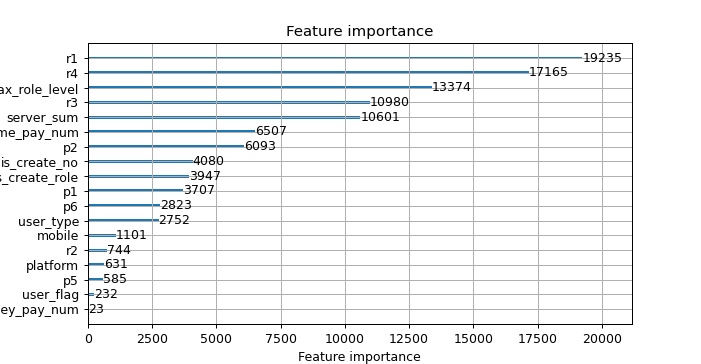

In [90]:
plt.figurelgb.plot_importance(model, max_num_features=20)
plt.show()

In [178]:
data.head()

,role_id,r1,r2,r3,r4,max_role_level,p1,p2,p3,p4,p5,p6,is_create_role,is_create_no,server_sum,platform,user_type,user_flag,mobile,game_pay_num,chmoney_pay_num,30d_pay_money
0,11263507,1,1,1,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
1,11265111,3,1,1,0.02,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
2,11265397,4,1,1,0.01,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
3,11269078,4,1,1,0.01,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
4,11271222,12,1,1,0.02,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0


In [186]:
np.random.randint(1,20,(3,4))

array([[ 5, 12, 12, 11],
       [15, 10, 19,  9],
       [ 2, 11, 18,  7]])

In [189]:
np.random.randn(7)

array([ 1.60473242,  1.75292908,  0.95736259,  1.02009238, -0.7096449 ,
       -0.47984969,  0.49383555])

In [190]:
np.random.choice(4, 5)

array([3, 2, 2, 1, 3])

In [204]:
arr = np.arange(9).reshape(3,3)
arr

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [206]:
np.random.shuffle(arr)
arr

array([[3, 4, 5],
       [6, 7, 8],
       [0, 1, 2]])

In [207]:
np.random.rand(3,4)

array([[0.02621617, 0.87974392, 0.79743125, 0.78469143],
       [0.40534938, 0.40863987, 0.0216347 , 0.99730864],
       [0.90660637, 0.46751216, 0.62524964, 0.50580441]])